In [ ]:
!pip install -q geopandas
!apt install -q proj-bin libproj-dev libgeos-dev -y
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q rasterio

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Pandas is a package containing additional functions to use data frames in Python
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import warnings
warnings.simplefilter('ignore')
import rasterio
import rasterio.plot
import numpy as np
import seaborn as sns
# These two lines allow the notebook to access the Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# This is the path to the project folder within the Google Drive.
file_path = "/content/drive/My Drive/"

Mounted at /content/drive


This cell contains some code we'll call later to convert between latitude and longitude co-ordinates and co-ordinates in the raster grids.

In [ ]:
def convert_xy_to_longlat(grid_x, grid_y):
  lon = ((grid_x / 6) - 180)
  lat = -((grid_y / 6) - 90)
  return (lon, lat)

def convert_longlat_to_xy(lon, lat):
  grid_x = (lon + 180) * 6
  grid_y = (-lat + 90) * 6
  return (grid_x, grid_y)

---
## Notebook 7

# Plotting WORLDCLIM Maps

I have downloaded the WORLDCLIM data from the worldclim website.

The data is available for 9 different models, I have downloaded six of them because the others had some missing data.

The models are listed below (this code might be useful later if we need to loop through all the models).

In [ ]:
models = ['BCC-CSM2-MR',
         'CNRM-CM6-1',
         'CNRM-ESM2-1',
         'CanESM5',
         'MIROC-ES2L',
         'MIROC6']

In [ ]:
models

['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'MIROC-ES2L', 'MIROC6']

There are four different climate scenarios.

In [ ]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

In [ ]:
scenarios

['ssp126', 'ssp245', 'ssp370', 'ssp585']

And there are five different time periods.

In [ ]:
time_periods = ['near_present', '2021-2040', '2041-2060', '2061-2080', '2081-2100']

In [ ]:
time_periods

['near_present', '2021-2040', '2041-2060', '2061-2080', '2081-2100']

The "near present" data is measurements from the past - from 1970 to 2000.  This data is a bit different because we don't need to apply the models or the SSPs - as it has already been measured rather than being predicted with a model.

I have saved the data on the Google Drive in "climate_data", then the model ID, then the SSP ID.

The worldclim datasets are in raster format - https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/what-is-raster-data.htm - these files have the suffix .tif.

These are basically grids of data which can be stacked on top of each other to give multiple layers of data.

First, we read in the raster formatted data from the Google Drive.  For now we'll just read the near-present data.


In [ ]:
raster = rasterio.open(file_path + "climate_data/near_present.tif")

The subunit of degrees latitude and longitude is minutes - there are 60 minutes in a degree.

These tables are in 10 minute increments - so 1/6 of a degree of latitude / longitude.

Longitude goes from -180 to 180 - so 360 in total - so we expect 360 * 6 = 2160 grid points on the longitude (x, width) axis.

Latitude goes from -90 to 90 - so 180 in total - so we expect 180 * 6 = 1080 grid points on the latitude (y, height) axis.

In [ ]:
raster.width, raster.height

(2160, 1080)

This means that we have a grid of data predicting the value of a variable at each of the points on a 2160 * 1080 grid on top of a map of the world.

These are quite small squares - in the map below each small square is 1 degree of latitude and 1 degree of longitude - so there would be 36 measurements per square.

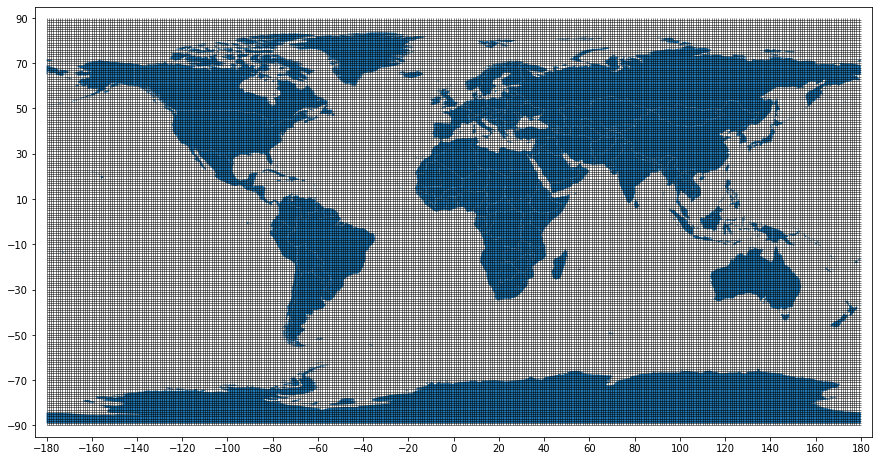

In [ ]:
# import the map
worldmap = gpd.read_file(file_path + "/country_boundaries_shapefiles/World_Countries__Generalized_.shp")
worldmap.to_csv('4088')

# make an empty figure
f = plt.figure(figsize=(15, 15))
a = f.add_subplot(111)

# add a line for each degree latitude and longitude
a.vlines(np.arange(-180, 180, 1), -90, 90, lw=0.5)
a.hlines(np.arange(-90, 90, 1), -180, 180, lw=0.5)

a.set_xlim(-185, 185)
a.set_ylim(-95, 95)

# set the position of the axis markers
a.set_xticks(np.arange(-180, 181, 20))
a.set_yticks(np.arange(-90, 91, 20))

# add the map
worldmap.plot(ax=a)

If we zoom in on a smaller area we can visualise the full grid.

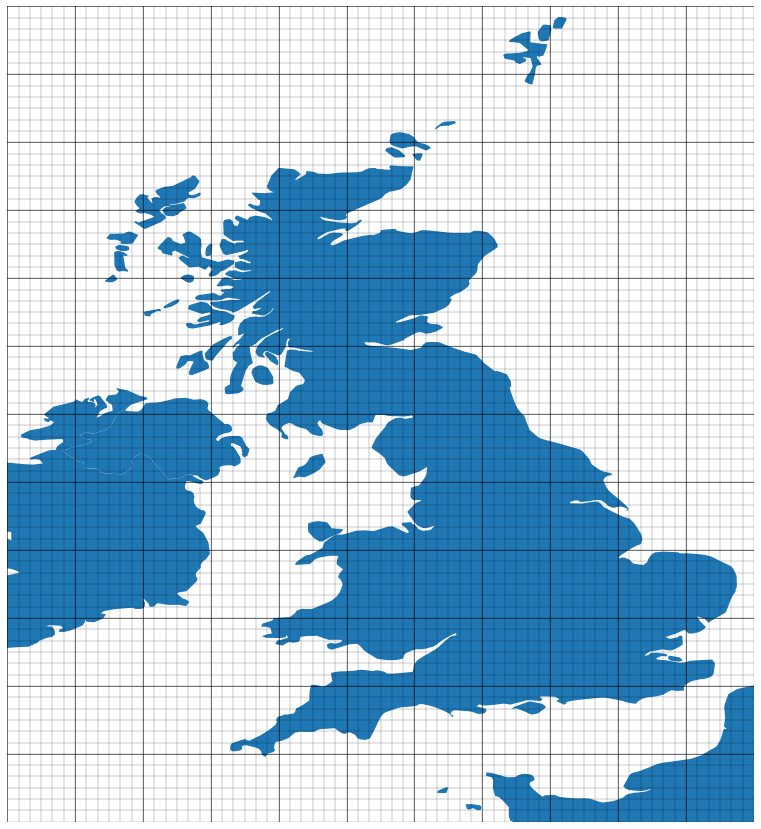

In [ ]:
# import the map
worldmap = gpd.read_file(file_path + "/country_boundaries_shapefiles/World_Countries__Generalized_.shp")
worldmap.to_csv('4088')

# define the latitude and longitude of the region we want to look at
lon_range = [-9, 2]
lat_range = [49, 61]

# make an empty figure
f = plt.figure(figsize=(15, 15))
a = f.add_subplot(111)

# add a line for each degree latitude and longitude
a.vlines(np.arange(-180, 180, 1), -90, 90, lw=0.5)
a.hlines(np.arange(-90, 90, 1), -180, 180, lw=0.5)

# add six subdivisions for each degree latitude and longitude
a.vlines(np.arange(-180, 180, 1/6), -90, 90, lw=0.2)
a.hlines(np.arange(-90, 90, 1/6), -180, 180, lw=0.2)

# set the x and y axis limits to just show the UK
a.set_xlim(lon_range)
a.set_ylim(lat_range)

# add the map
worldmap.plot(ax=a)

# hide the axis
a.set_axis_off()

For each of these points over a map of the world we will have 19 different measurements of climate for each of 5 time points - 1970 - 2000 (current), 2021-2040, 2041-2060, 2061-2080, and 2081-2100.

The 19 measurements are listed here: https://worldclim.org/data/bioclim.html

We also have these in a table - bioclim_variables.tsv

We can see that there are 19 variables using ```raster.count```.

In [ ]:
raster.count

19

I have made a table with the variable names and their maximum and minimum values.

At the moment we don't have units for these - we need to look them up.

I will read these into Python dictionaries to make them easier to use later.

In [ ]:
bioclim = pd.read_csv(file_path + "bioclim.tsv", sep="\t")

In [ ]:
bioclim

,variable_number,ID,name,minimum,maximum
0,1,BIO1,Annual_Mean_Temperature,-26.033854,39.753384
1,2,BIO2,Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_...,-3.091667,22.678125
2,3,BIO3,Isothermality_(BIO2/BIO7)_(×100),-47.100609,95.982124
3,4,BIO4,Temperature_Seasonality_(standard_deviation_×100),5.163034,2382.381592
4,5,BIO5,Max_Temperature_of_Warmest_Month,-8.600000,58.293751
5,6,BIO6,Min_Temperature_of_Coldest_Month,-48.281246,31.100000
6,7,BIO7,Temperature_Annual_Range_(BIO5-BIO6),1.433333,73.893753
7,8,BIO8,Mean_Temperature_of_Wettest_Quarter,-37.343754,47.507290
8,9,BIO9,Mean_Temperature_of_Driest_Quarter,-41.141666,48.394791
9,10,BIO10,Mean_Temperature_of_Warmest_Quarter,-11.806250,48.730209


In [ ]:
bioclim_name = dict(zip(bioclim['variable_number'], bioclim['name']))
bioclim_min = dict(zip(bioclim['variable_number'], bioclim['minimum']))
bioclim_max = dict(zip(bioclim['variable_number'], bioclim['maximum']))

We can convert the raster into a more useful format with ```raster.read```.  This gives us all the points in a matrix.

There are a couple of other corrections to apply. The data has many decimal places, we can round it to six decminal places using ```np.round```.  The measurements are only predicted or measured on land, so wherever this is the case the matrix has ```-inf``` as the value.  We can replace this with ```nan```.


In [ ]:
# convert the data into a matrix
grid = raster.read()

# round it to six decimal places
grid = np.round(grid, 6)

# replace "-inf" with "nan"
grid[grid == float('-inf'), ] = float('nan')

Now we have a stack of 19 grids, each showing the measurement of one climate variable for each grid square.

Each individual grid can be accessed using ```grid[x-1]``` where x is the variable number we are interested in.

E.g.if we are interested in variable 8 - mean temperature of driest quarter - we can access it as:


In [ ]:
grid[7]

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-41.355915, -42.012043, -42.0125  , ..., -42.836792, -42.842873,
        -41.570126],
       [-37.617085, -39.008083, -39.008415, ..., -39.709835, -39.723667,
        -37.809124],
       [-38.427708, -39.023125, -39.025208, ..., -39.738415, -39.74521 ,
        -38.600292]], dtype=float32)

It's a bit easier to see if we temporarily convert it to a dataframe.

In [ ]:
pd.DataFrame(grid[7])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,-41.528831,-42.201832,-42.200584,-42.196999,-44.445499,-49.663960,-53.777794,-56.323875,-56.313293,-56.314957,-56.316040,-56.313084,-56.306210,-56.299210,-56.293541,-56.290249,-56.285999,-56.282585,-56.279125,-56.274292,-56.270290,-56.265541,-56.259792,-56.255291,-56.250374,-56.246460,-56.243999,-56.238457,-56.234543,-56.231956,-56.228458,-56.223251,-56.219707,-56.218460,-56.214417,-56.208832,-56.202583,-56.199791,-56.192249,-56.185001,...,-56.947960,-56.960041,-56.977707,-56.993542,-57.007710,-57.023125,-57.040833,-57.065624,-57.077126,-57.087250,-57.097046,-57.114708,-57.135124,-57.146378,-57.162125,-57.180710,-57.188751,-57.202919,-57.213207,-57.226585,-57.239746,-57.251877,-57.259583,-57.272499,-57.289375,-57.296669,-57.306458,-57.315838,-57.327625,-57.344666,-57.351833,-57.355751,-57.367207,-54.786915,-50.610291,-45.296375,-43.008209,-43.015415,-43.022167,-41.717499
1076,-41.459457,-42.124458,-42.120834,-42.118710,-42.117542,-42.114040,-44.926376,-49.734249,-56.216042,-56.229210,-56.233917,-56.232460,-56.228416,-56.224960,-56.215832,-56.212540,-56.205750,-56.200001,-56.196583,-56.195126,-56.193417,-56.194416,-56.192627,-56.192543,-56.193249,-56.192249,-56.191418,-56.191666,-56.189999,-56.190666,-56.190914,-56.190582,-56.188000,-56.183838,-56.183960,-56.185291,-56.184959,-56.180622,-56.179790,-56.180416,...,-56.827457,-56.843334,-56.860374,-56.880207,-56.896999,-56.913792,-56.927502,-56.942169,-56.954544,-56.973625,-56.989834,-57.004082,-57.022209,-57.034584,-57.046333,-57.066376,-57.079754,-57.089668,-57.097332,-57.108418,-57.122833,-57.136166,-57.147541,-57.160126,-57.172169,-57.185627,-57.195335,-57.198666,-57.205002,-57.216499,-57.235374,-57.240082,-50.665417,-45.796124,-42.935627,-42.

We can plot each variable on a map to show how it varies by region.

It would be worthwhile to plot this information for a couple of different variables at different time points and under different models and see how it changes.  For now this is just to get used to the data, later we will pick some which are relevant for the report.

This code is a bit complicated, so I would recommend just changing  the variable number (here you do not need to subtract 1), the latitude and longitude range and the colour map.  There is an example below with a different latitude and longitude range.

There are different colour maps listed here:
https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

It is sometimes useful to use different colour maps for different variables - e.g. temperature and rainfall are most intuitive in different sets of colours.  You can reverse any colour map by adding "_r" to the end of the name e.g. "magma" vs "magma_r".

In [ ]:
# Choose the bioclim variable to plot
variable_number = 1


# First plot the whole map
lon_range = [-180, 180]
lat_range = [-60, 75]

colour_map = 'jet'

# choose a raster file to look at - either the near_present or a specific model, SSP and future time point.
# for near_present make the first value "near_present" and comment out the other two with a # symbol

model = 'BCC-CSM2-MR'
ssp = 'ssp585'
timepoint = '2021-2040'
# model = 'near_present'

if model == "near_present":
  raster_path = file_path + "climate_data/near_present.tif"
else:
  raster_path = file_path + "/climate_data/" + model + "/" + ssp + "/" + timepoint + ".tiff"

In [ ]:
timepoint = '2081-2100'
present_done = 0
for model in ['near_present',
              'BCC-CSM2-MR',
              'CanESM5',
              'MIROC6']:
    for ssp in ['ssp126', 'ssp585']:
        if model == "near_present" and present_done == 0:
            raster_path = file_path + "climate_data/near_present.tif"
            ssp = "NA"
            time_period = ""
            present_done = 1
        elif model != "near_present":
            raster_path = file_path + "/climate_data/" + model + "/" + ssp + "/" + timepoint + ".tiff"
        else:
          continue
        for variable_number in [1, 5, 6, 12, 13, 14]:
          if 'Precipitation' in bioclim_name[variable_number]:
            colour_map = 'terrain_r'
            iqr_1 = bioclim_min[variable_number]
            iqr_2 = np.percentile(np.arange(bioclim_min[variable_number], bioclim_max[variable_number]), 50)
          else:
            colour_map = 'jet'
            iqr_1 = np.percentile(np.arange(bioclim_min[variable_number], bioclim_max[variable_number]), 25)
            iqr_2 = bioclim_max[variable_number]
          raster = rasterio.open(raster_path)
          # convert the data into a matrix
          grid = raster.read()

          # round it to six decimal places
          grid = np.round(grid, 6)

          # replace "-inf" with "nan"
          grid[grid == float('-inf'), ] = float('nan')


          # Convert the latitude and longitude range to the units used
          # in this map projection
          axis_1 = convert_longlat_to_xy(lon_range[0], lat_range[0])
          axis_2 = convert_longlat_to_xy(lon_range[1], lat_range[1])

          # Calculates the ratio of the size of one latitude unit to one longitude unit
          # Just used to make the map the right aspect ratio
          ratio =  np.abs(lon_range[1] - lon_range[0]) / (np.abs(lat_range[1] - lat_range[0]))

          # Initially make a square map
          f = plt.figure(figsize=(10, 10))

          # Correct the map width as a proportion of its height
          f.set_figwidth(f.get_figheight() * ratio)

          # Start an empty plot
          plt.subplot(111)

          # iqr_1 = np.percentile(np.arange(bioclim_min[variable_number], bioclim_max[variable_number]), 25)

          # Draw the heatmap
          x = plt.imshow(grid[variable_number-1][0:930, :], cmap=colour_map,
                        vmin=iqr_1, vmax=iqr_2)

          # Add a title
          if model == "near_present":
            plt.title(bioclim_name[variable_number].replace("_", " ") + ": Near present measurements, 1970-2000")
          else:
            plt.title(bioclim_name[variable_number].replace("_", " ") + ": " + model + " prediction; " + ssp + "; " + timepoint)

          # Add the markers to the axis
          plt.xticks(np.arange(axis_1[0], axis_2[0]+1, 120), labels=np.arange(lon_range[0], lon_range[1]+1, 20))
          plt.yticks(np.arange(axis_2[1], axis_1[1]+1, 120), labels=(np.arange(lat_range[1], lat_range[0]-1, -20)))

          # Set the x and y axis limits to show the region of interest
          plt.xlim(axis_1[0], axis_2[0])
          plt.ylim(axis_1[1], axis_2[1])
          plt.colorbar(x)
          if model == "near_present":
            plt.savefig(file_path + "worldclim_plots/" + bioclim_name[variable_number] + "_near_present.png", dpi=300, bbox_inches='tight')
          else:
            plt.savefig(file_path + "worldclim_plots/" + bioclim_name[variable_number] + "_" + model + "_" + ssp + "_" + timepoint + ".png", dpi=300, bbox_inches='tight')
          
          plt.close()

In [ ]:
plt.imshow(grid[0])

We can zoom in a bit to see the individual grid squares.

The only thing which is different in this code is the lon_range and lat_range values.  You can look these up online for different countries or regions - there's a list of some here https://gist.github.com/graydon/11198540 (as long 1, lat 1, long 2, lat 2)

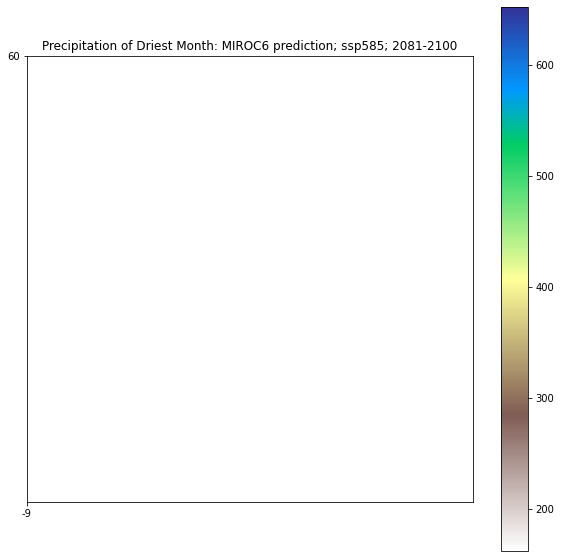

In [ ]:
# update the co-ordinates to UK only
lon_range = [-9, 2]
lat_range = [49, 60]

raster = rasterio.open(raster_path)
# convert the data into a matrix
grid = raster.read()

# round it to six decimal places
grid = np.round(grid, 6)

# replace "-inf" with "nan"
grid[grid == float('-inf'), ] = float('nan')


# Convert the latitude and longitude range to the units used
# in this map projection
axis_1 = convert_longlat_to_xy(lon_range[0], lat_range[0])
axis_2 = convert_longlat_to_xy(lon_range[1], lat_range[1])

# Calculates the ratio of the size of one latitude unit to one longitude unit
# Just used to make the map the right aspect ratio
ratio =  np.abs(lon_range[1] - lon_range[0]) / (np.abs(lat_range[1] - lat_range[0]))

# Initially make a square map
f = plt.figure(figsize=(10, 10))

# Correct the map width as a proportion of its height
f.set_figwidth(f.get_figheight() * ratio)

# Start an empty plot
plt.subplot(111)

iqr_1 = np.percentile(np.arange(bioclim_min[variable_number], bioclim_max[variable_number]), 25)

# Draw the heatmap
x = plt.imshow(grid[variable_number-1][0:930, :], cmap=colour_map,
               vmin=iqr_1, vmax=bioclim_max[variable_number])

# Add a title
if model == "near_present":
  plt.title(bioclim_name[variable_number].replace("_", " ") + ": Near present measurements, 1970-2000")
else:
  plt.title(bioclim_name[variable_number].replace("_", " ") + ": " + model + " prediction; " + ssp + "; " + timepoint)

# Add the markers to the axis
plt.xticks(np.arange(axis_1[0], axis_2[0]+1, 120), labels=np.arange(lon_range[0], lon_range[1]+1, 20))
plt.yticks(np.arange(axis_2[1], axis_1[1]+1, 120), labels=(np.arange(lat_range[1], lat_range[0]-1, -20)))

# Set the x and y axis limits to show the region of interest
plt.xlim(axis_1[0], axis_2[0])
plt.ylim(axis_1[1], axis_2[1])

plt.colorbar(x)
